Import Libraries

In [1]:
import jax
import flax
import optax
from jax import lax, random, numpy as jnp
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax.config import config
from flax import linen as nn

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# choose GPU
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'
jax.config.update("jax_enable_x64", True)

In [2]:
n_gpu = len(jax.devices())
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0),
 StreamExecutorGpuDevice(id=1, process_index=0)]

Projectile motion - tasks over distribution

In [3]:
# Function to generate analytical solution
@jit
def eval_u(x, v):
    Pe = v*L/k
    u = (1. - jnp.exp(Pe*x/L)) / (1. - jnp.exp(Pe))
    return u


# fixed PDE & BC parameters k & L
k = 1.
L = 1. 

Create tasks over distribution

In [4]:
# task / problem
task_all = jnp.linspace(5, 100, 20)
n_task = len(task_all)
print ('no. tasks = %d\n%s'%(n_task, task_all[:5]))

no. tasks = 20
[ 5. 10. 15. 20. 25.]


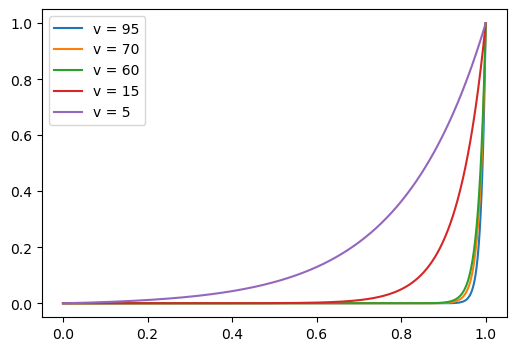

In [5]:
# plot some projectiles
r_task = 5
seed = 1
key, rng = random.split(random.PRNGKey(seed))
tasks = random.choice(key, n_task, (r_task,), replace=False)

fig = plt.figure(figsize=(6, 4))
for task in tasks:
    v = task_all[task]
    x = jnp.linspace(0, L, 1001).reshape(-1, 1)
    u = eval_u(x, v)
    plt.plot(x, u, label = 'v = %d'%(round(v)));
plt.legend();

Baldwinian PINN (B-PINN)

In [6]:
# construct randomization B-PINN for linear/nonlinear ODE/PDEs
@jit
def get_f(x, weights):
    f = jnp.hstack([jnp.sin(x * weights[0] + weights[1]),
                    nn.softplus(x * weights[2] + weights[3]),
                    jnp.tanh(x * weights[4] + weights[5]),
                    jnp.sin(x * weights[6] + weights[7]),
                    nn.softplus(x * weights[8] + weights[9]),
                    jnp.tanh(x * weights[10] + weights[11])])
    return f

# obtain f_x
def get_f_x(get_f, x, weights):
    f_x = jacfwd(get_f)(x, weights)
    return f_x

#obtain f_xx    
def get_f_xx(get_f, x, weights):
    f_xx = jacfwd(jacfwd(get_f))(x, weights)
    return f_xx

f_x_vmap = vmap(get_f_x, in_axes=(None, 0, None))
f_xx_vmap = vmap(get_f_xx, in_axes=(None, 0, None))

Least square problem

In [7]:
# no. neurons
n_node = 150

# no. sample
n_data = 1001

# generate weight & bias dist.
seed = 1
key, rng = random.split(random.PRNGKey(seed))
key, rng = random.split(rng) # update random generator
weights_n = random.truncated_normal(key, shape=(n_node, 6), lower=-1, upper=1)
key, rng = random.split(rng) # update random generator
weights_u = random.uniform(key, (n_node, 6), minval=-1, maxval=1)

# regularization
lamb = 1e-4

In [8]:
# compute hidden node outputs / derivaties & construct least square problem
@jit
def compute_ls_task(param, v):
    # generate weight & bias dist. (given param)
    weights = jnp.hstack([weights_n* param[:6] + param[6:12], weights_u* param[12:18] + param[18:-1]]).T
    # generate coefs & sample (given v)
    x = jnp.linspace(0, L, n_data).reshape(-1, 1)
    label_u = eval_u(x, v)
    # populate PDE sub-matrix
    f_x = f_x_vmap(get_f, x, weights)[:,:,0]
    f_xx = f_xx_vmap(get_f, x, weights)[:,:,0,0]
    # PDE: v*u_x - k*u_xx = 0
    pde = v*f_x - k*f_xx
    # populate BC sub-matrix
    ic_1 = get_f(x[0], weights)
    ic_2 = get_f(x[-1], weights)
    # construct least square problem - populate A (w_x, w_y)
    A = jnp.vstack([pde, ic_1, ic_2])
    # construct least square problem - populate b
    pad0 = jnp.zeros((n_data, 1))
    b = jnp.vstack([pad0, label_u[0], label_u[-1]]) 
    # alternative solve (n_sample >> n_node)
    reg = lamb *param[-1]
    w = jnp.linalg.inv(reg*jnp.eye(A.shape[1]) + (A.T@A))@A.T@b
    ssr = np.sum((b - A @ w)**2)
    return w, ssr, weights

@jit
def compute_ssr_task(param, task):
    # generate weight & bias dist. (given param)
    weights = jnp.hstack([weights_n* param[:6] + param[6:12], weights_u* param[12:18] + param[18:-1]]).T
    # generate coefs & sample (given task)
    v = task_all[task]
    x = jnp.linspace(0, L, n_data).reshape(-1, 1)
    label_u = eval_u(x, v)
    # populate PDE sub-matrix
    f_x = f_x_vmap(get_f, x, weights)[:,:,0]
    f_xx = f_xx_vmap(get_f, x, weights)[:,:,0,0]
    # PDE: v*u_x - k*u_xx = 0
    pde = v*f_x - k*f_xx
    # populate BC sub-matrix
    ic_1 = get_f(x[0], weights)
    ic_2 = get_f(x[-1], weights)
    # construct least square problem - populate A (w_x, w_y)
    A = jnp.vstack([pde, ic_1, ic_2])
    # construct least square problem - populate b
    pad0 = jnp.zeros((n_data, 1))
    b = jnp.vstack([pad0, label_u[0], label_u[-1]]) 
    # alternative solve (n_sample >> n_node)
    reg = lamb *param[-1]
    w = jnp.linalg.inv(reg*jnp.eye(A.shape[1]) + (A.T@A))@A.T@b
    ssr = np.sum((b - A @ w)**2)
    # mse (given task)
    u = get_f(x, weights) @ w
    mse = jnp.mean(jnp.square(label_u - u))  
    return ssr, mse

compute_ssr_task = jax.vmap(compute_ssr_task)
batch_ssr_task = jax.pmap(compute_ssr_task)

In [9]:
# solution
def get_u(x, weights):
    f = get_f(x, weights)
    return (f @ w)

In [10]:
from evojax.algo import CMA_ES_JAX

stdev = 1.
pop_size = 20
solver = CMA_ES_JAX(
         pop_size=pop_size, init_stdev=stdev, # adjust pop_size and init_stdev (e.g., 0.1, 0.5, 1, 5, 10)
         param_size=25, seed=seed)

# no. task to choose from a distribution
r_task = 10

In [11]:
max_iters = 200

store = []
convergence = []

runtime = 0
train_iter = 0
while (runtime < 600) and (train_iter < max_iters):
    start = time.time()
    # fitness evaluation
    params = solver.ask()
    # store weights after 2, 20 & 200 iterations
    if ((train_iter + 1) == 2) | ((train_iter + 1) == 20) | ((train_iter + 1) == 200):
        store.append(params)
    # repeat for a distribution of task (pop_size * r_task)
    params = jnp.tile(params, (r_task, 1)) # repeat for a distribution of task
    key, rng = random.split(rng) # update random generator
    tasks = random.choice(key, n_task, (r_task,), replace=False)
    tasks = jnp.repeat(tasks, repeats=pop_size) # repeat for each candidate solution
    # multi GPU runs
    ssr, mse = batch_ssr_task(params.reshape(n_gpu, int(len(params)/n_gpu), -1), tasks.reshape(n_gpu, -1))
    #ssr, mse = ssr.flatten(), mse.flatten()
    ssr = ssr.reshape(-1, pop_size).mean(axis=0)
    mse = mse.reshape(-1, pop_size).mean(axis=0)
    # updates the weights through the solver
    scores = - (mse + ssr)
    solver.tell(fitness=scores)
    # this is the average loss of all the population of parameters
    maxpos = jnp.argmax(scores)
    end = time.time()
    # update
    runtime += (end - start)
    # print out
    print('Iter = %5d | Time = %.2fs | LOSS = %.2e  || - SSR = %.2e, MSE = %.2e' % (train_iter + 1, runtime, -scores[maxpos],
                                                                                    ssr[maxpos], mse[maxpos]))
    convergence.append([train_iter + 1, runtime, -scores[maxpos], ssr[maxpos], mse[maxpos]])
    train_iter += 1
    
store = jnp.array(store)
convergence = jnp.array(convergence)

Iter =     1 | Time = 5.99s | LOSS = 6.62e-01  || - SSR = 4.49e-01, MSE = 2.12e-01
Iter =     2 | Time = 7.71s | LOSS = 6.55e-01  || - SSR = 4.47e-01, MSE = 2.08e-01
Iter =     3 | Time = 8.93s | LOSS = 6.62e-01  || - SSR = 4.49e-01, MSE = 2.13e-01
Iter =     4 | Time = 10.16s | LOSS = 7.41e-01  || - SSR = 5.00e-01, MSE = 2.41e-01
Iter =     5 | Time = 11.38s | LOSS = 6.87e-01  || - SSR = 4.65e-01, MSE = 2.22e-01
Iter =     6 | Time = 12.61s | LOSS = 7.24e-01  || - SSR = 4.90e-01, MSE = 2.33e-01
Iter =     7 | Time = 13.83s | LOSS = 6.99e-01  || - SSR = 4.74e-01, MSE = 2.25e-01
Iter =     8 | Time = 15.06s | LOSS = 6.17e-01  || - SSR = 4.19e-01, MSE = 1.98e-01
Iter =     9 | Time = 16.28s | LOSS = 6.28e-01  || - SSR = 4.25e-01, MSE = 2.03e-01
Iter =    10 | Time = 17.51s | LOSS = 6.64e-01  || - SSR = 4.48e-01, MSE = 2.15e-01
Iter =    11 | Time = 18.73s | LOSS = 5.41e-01  || - SSR = 3.66e-01, MSE = 1.75e-01
Iter =    12 | Time = 19.96s | LOSS = 5.60e-01  || - SSR = 3.78e-01, MSE = 1.82

Iter =    99 | Time = 126.68s | LOSS = 1.09e-07  || - SSR = 9.39e-08, MSE = 1.49e-08
Iter =   100 | Time = 127.91s | LOSS = 1.14e-07  || - SSR = 1.01e-07, MSE = 1.30e-08
Iter =   101 | Time = 129.13s | LOSS = 7.32e-08  || - SSR = 6.54e-08, MSE = 7.86e-09
Iter =   102 | Time = 130.36s | LOSS = 6.14e-08  || - SSR = 5.58e-08, MSE = 5.63e-09
Iter =   103 | Time = 131.58s | LOSS = 4.06e-08  || - SSR = 3.71e-08, MSE = 3.44e-09
Iter =   104 | Time = 132.81s | LOSS = 4.48e-08  || - SSR = 3.86e-08, MSE = 6.24e-09
Iter =   105 | Time = 134.04s | LOSS = 8.07e-08  || - SSR = 7.18e-08, MSE = 8.84e-09
Iter =   106 | Time = 135.26s | LOSS = 7.37e-08  || - SSR = 6.91e-08, MSE = 4.60e-09
Iter =   107 | Time = 136.50s | LOSS = 4.72e-08  || - SSR = 4.27e-08, MSE = 4.48e-09
Iter =   108 | Time = 137.73s | LOSS = 6.26e-08  || - SSR = 5.55e-08, MSE = 7.09e-09
Iter =   109 | Time = 138.97s | LOSS = 2.85e-08  || - SSR = 2.45e-08, MSE = 4.04e-09
Iter =   110 | Time = 140.21s | LOSS = 7.43e-08  || - SSR = 6.56e

Iter =   196 | Time = 246.66s | LOSS = 1.24e-08  || - SSR = 9.03e-09, MSE = 3.38e-09
Iter =   197 | Time = 247.90s | LOSS = 1.49e-08  || - SSR = 1.11e-08, MSE = 3.80e-09
Iter =   198 | Time = 249.14s | LOSS = 1.40e-08  || - SSR = 1.24e-08, MSE = 1.56e-09
Iter =   199 | Time = 250.37s | LOSS = 1.65e-08  || - SSR = 1.30e-08, MSE = 3.44e-09
Iter =   200 | Time = 251.61s | LOSS = 1.77e-08  || - SSR = 1.59e-08, MSE = 1.81e-09


In [12]:
solver.best_params

DeviceArray([-241.4546951 ,  -58.05349267,    1.18837393, -170.59968366,
              -15.56085468,   -7.7672702 ,  247.10737188,   65.39971789,
                0.54243979,  -15.30295018, -191.4320552 ,  191.86013802,
              158.62631619,  -23.44364475,  -82.01001202,  -18.44732548,
                4.65310434,  -20.15861902,   -0.87538653,  -70.47981588,
               -3.57593952,  -53.3762909 , -332.79665296,  319.50592273,
               88.79953265], dtype=float64)

Convergence & prediction on [ test ] tasks

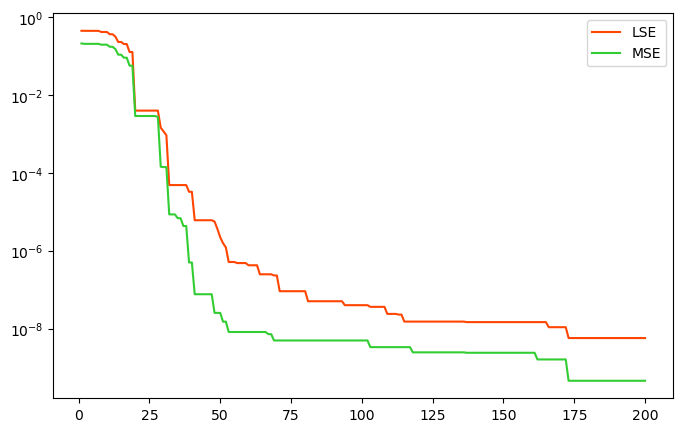

In [14]:
# plot convergence
fig = plt.figure(figsize=(8, 5))
# smooth the MSE & SSR
_mse = np.array(convergence[:,4].copy())
for i in range(1, len(_mse)): _mse[i] = min(_mse[i], _mse[i-1])  
_ssr = np.array(convergence[:,3].copy())
for i in range(1, len(_ssr)): _ssr[i] = min(_ssr[i], _ssr[i-1])  
plt.plot(convergence[:,0], _ssr, label='LSE', c='orangered');
plt.plot(convergence[:,0], _mse, label='MSE', c='limegreen');
plt.yscale('log'); plt.xlabel('Iteration'); plt.ylabel('LSE / MSE'); plt.legend(); #plt.ylim(1e-10, 1e1);

In [15]:
# prediction on test tasks
res_test = []
for v in range(1, 111):    
    x = jnp.linspace(0, L, n_data).reshape(-1, 1)
    label_u = eval_u(x, v)
    # solve problem
    w, ssr, weights = compute_ls_task(solver.best_params, v)
    u = get_u(x, weights)
    mse = jnp.mean(jnp.square(label_u - u))
    #print('v = %d | SSR = %.2e | MSE = %.2e'%(round(v), ssr, mse));
    res_test.append([round(v), ssr, mse])
    
# summary statistics
res_test = pd.DataFrame(jnp.array(res_test), columns=['v', 'SSR', 'MSE'])
res_test['MSE'].describe()

count    1.100000e+02
mean     3.850559e-09
std      4.669184e-09
min      3.517944e-13
25%      3.286093e-10
50%      1.676170e-09
75%      6.116617e-09
max      1.897673e-08
Name: MSE, dtype: float64

Prediction on selected test tasks - showing Baldwinian evolution progress

After 2 iterations

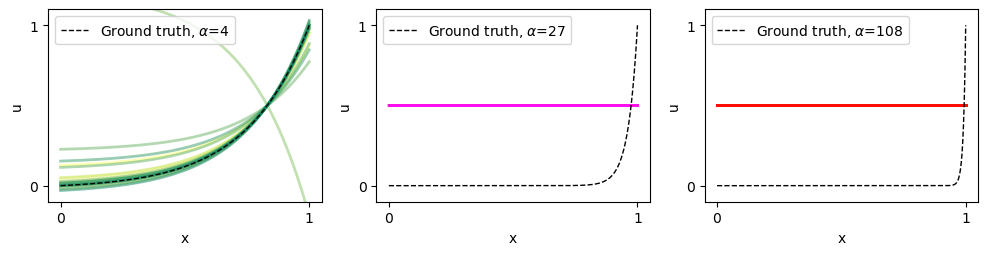

In [16]:
res_test = []
for v in [4, 27, 108]:     
    x = jnp.linspace(0, L, n_data).reshape(-1, 1)
    label_u = eval_u(x, v)
    # solve problem
    for param in store[0]:
        w, ssr, weights = compute_ls_task(param, v)
        u = get_u(x, weights)
        res_test.append(u)
res_test = jnp.array(res_test)

# plot all
fig = plt.figure(figsize=(12, 2.5))
plt.subplots_adjust(wspace=0.2)
colors = [plt.cm.summer_r(np.linspace(0, 1, 20)),
          plt.cm.spring_r(np.linspace(0, 1, 20)),
          plt.cm.autumn_r(np.linspace(0, 1, 20))]
p = 0
for v in [4, 27, 108]: 
    ax1 = fig.add_subplot(1,3,p+1)
    label_u = eval_u(x, v)
    for i in range(0+(20*p), 20+(20*p)):
        plt.plot(x, res_test[i], color=colors[p][i-20*p], lw=2., alpha=.5);
    plt.plot(x, label_u, c='k', lw=1, linestyle='--', label = r'Ground truth, $\alpha$=%d'%v);
    plt.xlabel('x'); plt.ylabel('u'); plt.legend(loc='upper left'); plt.ylim(-.1, 1.1);
    plt.xticks([0,1], [0,1]); plt.yticks([0,1], [0,1]);    
    p += 1

After 20 iterations

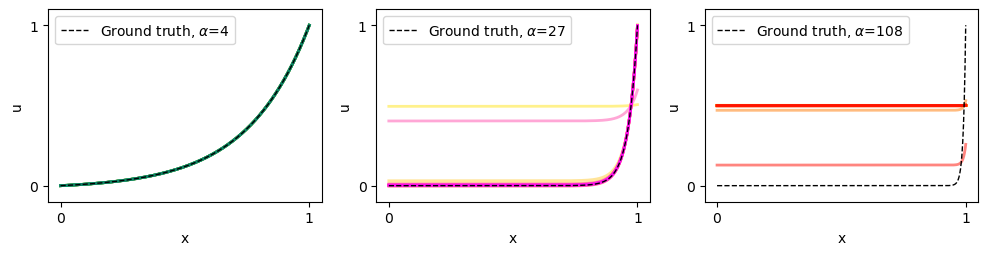

In [17]:
res_test = []
for v in [4, 27, 108]:    
    x = jnp.linspace(0, L, n_data).reshape(-1, 1)
    label_u = eval_u(x, v)
    # solve problem
    for param in store[1]:
        w, ssr, weights = compute_ls_task(param, v)
        u = get_u(x, weights)
        res_test.append(u)
res_test = jnp.array(res_test)

# plot all
fig = plt.figure(figsize=(12, 2.5))
plt.subplots_adjust(wspace=0.2)
colors = [plt.cm.summer_r(np.linspace(0, 1, 20)),
          plt.cm.spring_r(np.linspace(0, 1, 20)),
          plt.cm.autumn_r(np.linspace(0, 1, 20))]
p = 0
for v in [4, 27, 108]: 
    ax1 = fig.add_subplot(1,3,p+1)
    label_u = eval_u(x, v)
    for i in range(0+(20*p), 20+(20*p)):
        plt.plot(x, res_test[i], color=colors[p][i-20*p], lw=2., alpha=.5);
    plt.plot(x, label_u, c='k', lw=1, linestyle='--', label = r'Ground truth, $\alpha$=%d'%v);
    plt.xlabel('x'); plt.ylabel('u'); plt.legend(loc='upper left'); plt.ylim(-.1, 1.1);
    plt.xticks([0,1], [0,1]); plt.yticks([0,1], [0,1]);    
    p += 1

After 200 iterations

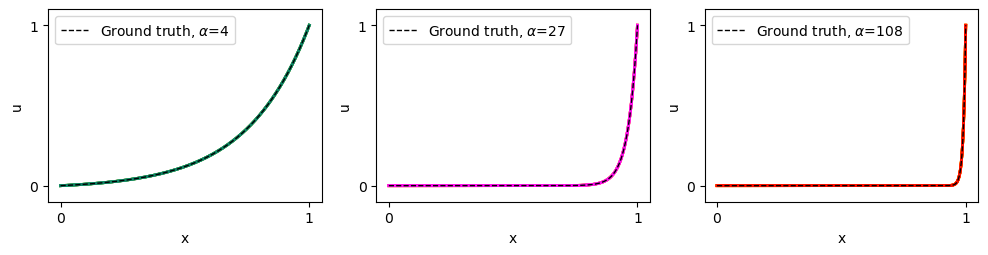

In [18]:
res_test = []
for v in [4, 27, 108]:    
    x = jnp.linspace(0, L, n_data).reshape(-1, 1)
    label_u = eval_u(x, v)
    # solve problem
    for param in store[2]:
        w, ssr, weights = compute_ls_task(param, v)
        u = get_u(x, weights)
        res_test.append(u)
res_test = jnp.array(res_test)

# plot all
fig = plt.figure(figsize=(12, 2.5))
plt.subplots_adjust(wspace=0.2)
colors = [plt.cm.summer_r(np.linspace(0, 1, 20)),
          plt.cm.spring_r(np.linspace(0, 1, 20)),
          plt.cm.autumn_r(np.linspace(0, 1, 20))]
p = 0
for v in [4, 27, 108]: 
    ax1 = fig.add_subplot(1,3,p+1)
    label_u = eval_u(x, v)
    for i in range(0+(20*p), 20+(20*p)):
        plt.plot(x, res_test[i], color=colors[p][i-20*p], lw=2., alpha=.5);
    plt.plot(x, label_u, c='k', lw=1, linestyle='--', label = r'Ground truth, $\alpha$=%d'%v);
    plt.xlabel('x'); plt.ylabel('u'); plt.legend(loc='upper left'); plt.ylim(-.1, 1.1);
    plt.xticks([0,1], [0,1]); plt.yticks([0,1], [0,1]);    
    p += 1